# Using thermodynamic analysis to guide metabolic engineering
DO 12-6-2018  
Using Python 3 and eQuilibrator API  


In [29]:
#Changing directory to the github home folder /Ctherm_thermo
import os
os.chdir('/Users/satyakam/Dropbox/work/equilibrator-api-master')
import sys
sys.path.append('/Users/satyakam/Dropbox/work/sbtab-0.9.64')
#sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master')
#sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master/src/equilibrator_api')
sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master/src')
#sys.path.append('/Users/satyakam/Dropbox/work')

In [30]:
import numpy as np
from numpy import array, eye, log, zeros, matrix
from numpy.linalg import inv, solve
import pandas as pd
from equilibrator_api import Reaction, ComponentContribution, ReactionMatcher, CompoundMatcher, ParseError, Pathway
from equilibrator_api.bounds import Bounds
%matplotlib inline

## Set up translator for KEGG IDs
Note: I set these up as dataframes because I was troubleshooting an issue with duplicate KEGG IDs. Eventually I think these should be set up as dictionaries, to make the code more readable

In [31]:
# make a dictionary to translate KEGG IDs into human-readable abbreviations
keggTranslatorDf = pd.read_excel('KEGG_SEED_DO.xls')
kt = keggTranslatorDf #short name for easier typing

# translate KEGG ID to long name
ktn = kt.loc[:,['KEGG ID(S)', 'PRIMARY NAME']]
ktn['KEGG ID(S)'] = ktn['KEGG ID(S)'].str.lower() # set to lower case for better matching
ktn.set_index('KEGG ID(S)', inplace = True)

# translate long name to KEGG ID
# the original dictionaries sometimes had trouble with duplicate KEGG IDs. If there are duplicates, make sure to choose the lowest number
ntk = kt.loc[:,['PRIMARY NAME', 'KEGG ID(S)']].sort_values(by = ['KEGG ID(S)'], ascending = True)
ntk['PRIMARY NAME'] = ntk['PRIMARY NAME'].str.lower() # set to lower case for better matching
ntk = ntk.groupby('PRIMARY NAME').first() # take the first KEGG ID in each group

# translate KEGG ID to abbreviation
kta = kt.loc[:,['KEGG ID(S)', 'ABBREVIATION']]
kta['KEGG ID(S)'] = kta['KEGG ID(S)'].str.lower() # set to lower case for better matching
kta.set_index('KEGG ID(S)', inplace = True)

# translate abbreviation to KEGG ID
atk = kt.loc[:,['ABBREVIATION', 'KEGG ID(S)']]
atk['ABBREVIATION'] = atk['ABBREVIATION'].str.lower() # set to lower case for better matching
atk.set_index('ABBREVIATION', inplace = True)

atkDict = dict(zip(kt['ABBREVIATION'].values, kt['KEGG ID(S)'].values))

## Set up model
* Choose reactions
* Set fluxes
* Set concentration bounds
* Set pH and ionic strength

In [32]:
allRxnDf = pd.read_excel('cth_thermo_model_DO.xlsx', sheet_name = 'reactions')
allRxnDf[:5]

,Name,PlaintextFormula,AbbreviationFormula,KeggFormula,Notes,flux1,flux2,flux3,flux4
0,CBtx,H2O + ATP <=> ADP + Phosphate,h2o + atp <=> adp + pi,C00001 + C00002 <=> C00008 + C00009,ATP hydrolysis for cellobiose transport,1,1,1,1
1,CBP,Phosphate + Cellobiose <=> D-Glucose + Glucose...,pi + cellb <=> glc-D + g1p,C00009 + C00185 <=> C00031 + C00103,NaN,1,1,1,1
2,GLK,D-Glucose + GTP <=> D-Glucose-6-phosphate + GDP,glc-D + gtp <=> g6p + gdp,C00031 + C00044 <=> C00092 + C00035,NaN,1,1,1,1
3,PGMT,Glucose-1-phosphate <=> D-glucose-6-phosphate,g1p <=> g6p,C00103 <=> C00092,NaN,1,1,1,1
4,PGI,D-Glucose-6-phosphate <=> D-Fructose-6-phosphate,g6p <=> f6p,C00092 <=> C00085,NaN,2,2,2,2


In [33]:
# choose a flux set, and drop all of the zero-flux reactions
fluxSet = 'flux1'
selectedRxnDf = allRxnDf.loc[allRxnDf[fluxSet] != 0, ['Name', 'AbbreviationFormula', 'KeggFormula', fluxSet]]
selectedRxnDf.rename(columns = {fluxSet:'flux'}, inplace = True) # rename the flux columns to 'flux' to simplify subsequent
                                                                 # processing
selectedRxnDf

,Name,AbbreviationFormula,KeggFormula,flux
0,CBtx,h2o + atp <=> adp + pi,C00001 + C00002 <=> C00008 + C00009,1
1,CBP,pi + cellb <=> glc-D + g1p,C00009 + C00185 <=> C00031 + C00103,1
2,GLK,glc-D + gtp <=> g6p + gdp,C00031 + C00044 <=> C00092 + C00035,1
3,PGMT,g1p <=> g6p,C00103 <=> C00092,1
4,PGI,g6p <=> f6p,C00092 <=> C00085,2
5,PFK-PPi,ppi + f6p <=> pi + fdp + h,C00013 + C00085 <=> C00009 + C00354 + C00080,2
7,FBA,fdp <=> dhap + g3p,C00354 <=> C00111 + C00118,2
8,TPI,dhap <=> g3p,C00111 <=> C00118,2
9,GAPDH,pi + nad + g3p <=> nadh + 13dpg,C00009 + C00003 + C00118 <=> C00004 + C00236,4
12,PGK-GTP,gdp + 13dpg <=> gtp + 3pg,C00035 + C00236 <=> C00044 + C00197,4


In [34]:
# parse the KeggFormula column to create eQuilibrator Reaction objects
# create reaction list
reactions = []
for i, row in selectedRxnDf.iterrows():
    rxn = Reaction.parse_formula(row['KeggFormula'], rid = row['Name'])
    if (rxn.check_full_reaction_balancing()):
        reactions.append(rxn)
    else:
        print('Error: reaction {} is not balanced'.format(row['AbbreviationFormula']))
        
# create flux list
fluxes = selectedRxnDf['flux'].values

# need to declare pH and ionic strength constants at the beginning
PH = 7.0
IS = 0.1

# calculate dGO_r_primes
dG0_r_primes = []
for r in reactions:
    result = r.dG0_prime(pH = PH, ionic_strength = IS)
    #print(result)
    dG0_r_primes.append(result)

In [35]:
# set up the model
pp = Pathway(reactions = reactions, fluxes = fluxes, dG0_r_primes = dG0_r_primes)

In [36]:
# set up the reaction bounds
# make a dataframe with the upper and lower bounds
def bounds_to_df(compounds, bounds):
    """
    Make a dataframe with concentrations
    Args:
        compounds = list of KEGG IDs
        bounds = equilibrator-api bounds object
    """
    boundsDf = pd.DataFrame(compounds, columns = ['Compound:Identifiers:kegg.compound']) # I had to choose this clunky column name to make it work with bounds.py 
                                                                                                    # from_dataframe method
    boundsDf['Name'] = boundsDf['Compound:Identifiers:kegg.compound'].apply(lambda x: kta.loc[x.lower()]) # add abbreviations
    boundsDf['Concentration:Max'] = boundsDf['Compound:Identifiers:kegg.compound'].apply(lambda x: bounds.GetUpperBound(x))
    boundsDf['Concentration:Min'] = boundsDf['Compound:Identifiers:kegg.compound'].apply(lambda x: bounds.GetLowerBound(x))
    return boundsDf

In [37]:
pp.bounds.SetBounds(atk.loc['etoh'].iloc[0], 1,1 )

In [38]:
saveDirs = ["P1_ppi_ratio"]
ppi_ratio = [1,2,3,4,5,6,7,8,9,10,12,15,18,20]
exp_data_file = "ctherm_exp_data.txt"
exp_data = []
all_data = {}
f = open(exp_data_file, "r")
l = f.readline()
l = f.readline()
mets_constr = [i for i in l.strip("\n").split(" ") if i != ""]
l = f.readline()
while l != "":
    data = [float(i) for i in l.strip("\n").split(" ") if i != ""]
    exp_data.append(dict(zip(mets_constr, data)))
    l = f.readline()

f.close()
Uf = 2 #Uncertainity factor 
ref_conc0 = {'C00469': 10,
            'C00004': 0.08,
            'C00024': 0.83,
            'C00002': 2.70,
            'C00008': 0.11,
            'C00020': 0.22,
            'C00354': 1.50,
            'C00092': 8.19,
            'C00074': 0.69,
            'C00005': 0.38,
            'C00022': 12.65,
            'C00103': 6.66,

            }
for k in range(len(saveDirs)):
    ref_conc = {k: float(v) / 1000 for k,v in ref_conc0.items()}
    for cpd, conc in ref_conc.items():
        pp.bounds.SetBounds(cpd, conc / Uf,conc * Uf )

    for r in ppi_ratio:
        dictCur ={}
        all_data[r] ={}
        # fix PPI/PI ratio
        pp.bounds.SetBounds('C00013', 1e-3 * r,1e-3 * r )
        pp.bounds.SetBounds('C00009', 1e-3 * 10,1e-3 * 10 )
        t = 0
        #print p["bounds"]
        for d in exp_data:
            for cpd, conc in ref_conc.items():
                if cpd == "C00469":
                    # absolute EtOH conc
                    pp.bounds.SetBounds(cpd,d[cpd], d[cpd])
                elif cpd == "C00004":
                    # NADH/NAD+ ratio
                    pp.bounds.SetBounds(cpd, 1/Uf * conc * float(d[cpd]) / 0.3, Uf * conc * float(d[cpd]) / 0.3)
                #elif cpd == "C00044":
                    # GTP/GDP ratio
                #    pp.bounds.SetBounds(cpd,1/Uf * conc * float(d['C00002']), Uf * conc * float(d['C00002']))'''
                #elif cpd == "C00008" and t == 0:
                    #p['bounds'][cpd] = (conc, ) * 2
                elif cpd not in ["C00008","C00085","C00006","C00003","C00118","C00011","C00197","C00010","C00035","C00044"]:
                    # other relative data
                    pp.bounds.SetBounds(cpd,1/Uf * conc * d[cpd], Uf * conc * d[cpd])

            
            # calculate the min-max driving force
            mdf_data = pp.calc_mdf()
            #mdf_data.mdf_plot
            # store the data
            dictCur[t] = {'mdf': mdf_data.mdf}
            dictCur[t]["reaction prices"] = {r.reaction.reaction_id: float(r.shadow_price) for r in mdf_data.reaction_data}
            dictCur[t]["gibbs energies"] = {r.reaction.reaction_id: float(r.dGr) for r in mdf_data.reaction_data}
            dictCur[t]["concentrations"] = {str(c.compound): float(c.concentration) for c in mdf_data.compound_data}
            dictCur[t]["compound prices"] = {str(c.compound): float(c.shadow_price) for c in mdf_data.compound_data}

            all_data[r] = dictCur
            t += 1

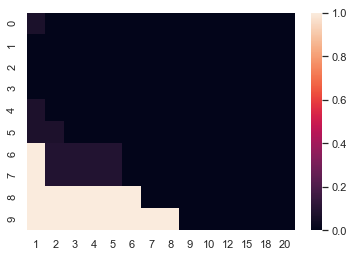

In [39]:
import seaborn as sns
sns.set()
fng_data={}
for r in [1,2,3,4,5,6,7,8,9,10,12,15,18,20]:
    fng_data[r]={}
    for t in range(10):
        fng_data[r][t] = all_data[r][t]["reaction prices"]["PFK-PPi"]
import pandas as pd
df = pd.DataFrame.from_dict(fng_data)
sns.heatmap(df)
#xlabel('PPi conc in mM')
#ylabel('timepoints')

Text(0.5, 1.0, 'MDF vs PPI conc.')

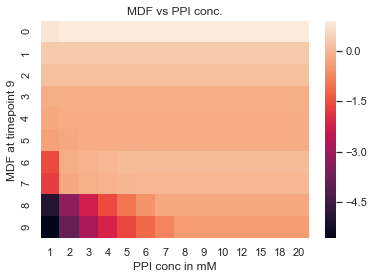

In [40]:
import matplotlib.pyplot as plt
mdf_data={}
for r in [1,2,3,4,5,6,7,8,9,10,12,15,18,20]:
    mdf_data[r]={}
    for t in range(10):
        mdf_data[r][t] = all_data[r][t]["mdf"]
y={}
df = pd.DataFrame.from_dict(mdf_data)
sns.heatmap(df)
for r in [1,2,3,4,5,6,7,8,9,10,12,15,18,20]:
    y[r] = float(mdf_data[r][9]) 
plt.plot(*zip(*sorted(y.items())))
plt.xlabel('PPI conc in mM')
plt.ylabel('MDF at timepoint 9')
plt.title('MDF vs PPI conc.')

Text(0.5, 1.0, 'MDF vs PPI conc.')

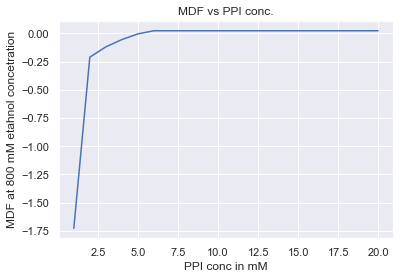

In [45]:
y={}
for r in [1,2,3,4,5,6,7,8,9,10,12,15,18,20]:
    y[r] = float(mdf_data[r][7]) 
plt.plot(*zip(*sorted(y.items())))
plt.xlabel('PPI conc in mM')
plt.ylabel('MDF at 800 mM etahnol concetration')
plt.title('MDF vs PPI conc.')

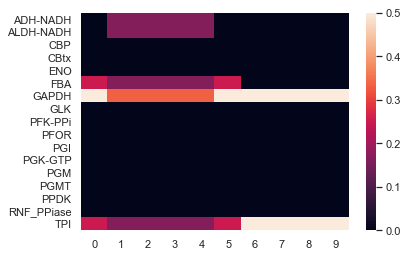

In [16]:
fng_data={}
for t in range(10):
    fng_data[t] = all_data[7][t]["reaction prices"]
df = pd.DataFrame.from_dict(fng_data)
sns.heatmap(df)

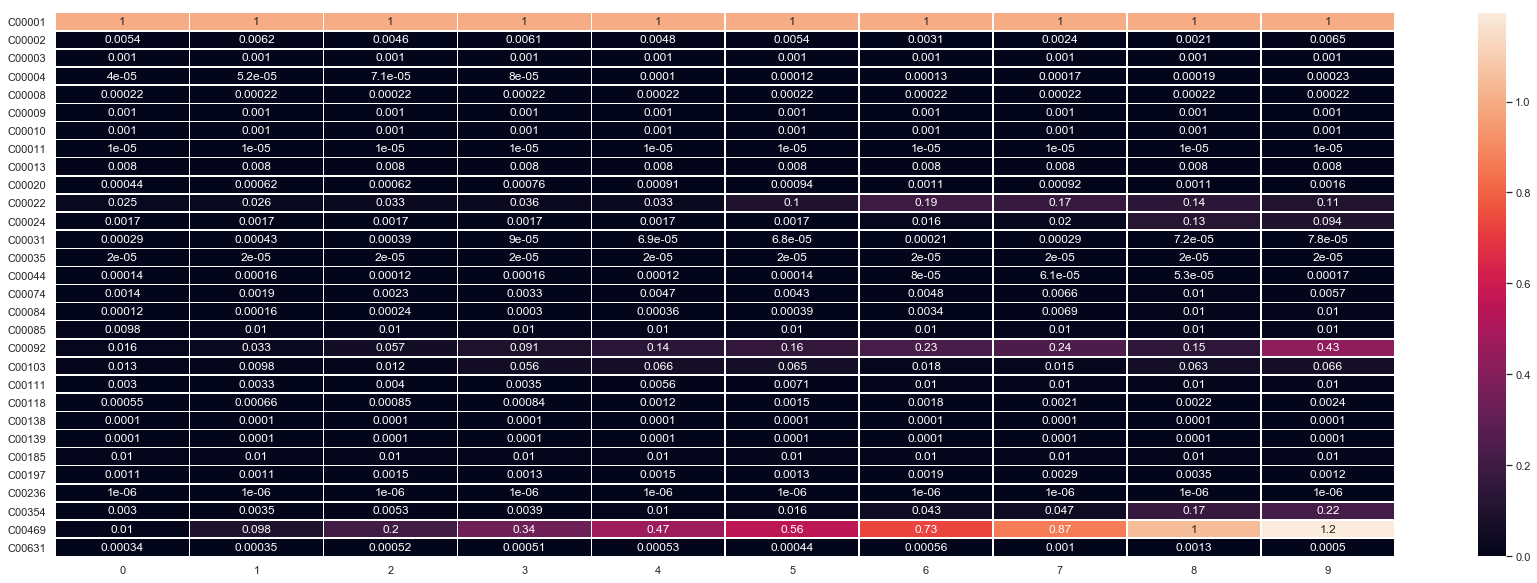

In [29]:
fng_data={}
for t in range(10):
    fng_data[t] = all_data[8][t]["concentrations"]
df = pd.DataFrame.from_dict(fng_data)
f, ax = plt.subplots(figsize=(30, 10))
sns.heatmap(df,annot= True, linewidths=.5, ax=ax)

Text(0.5, 1.0, 'MDF vs time points')

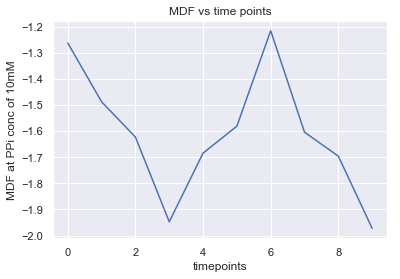

In [42]:
y={}
for t in range(10):
    y[t] = float(mdf_data[6][t]) 
plt.plot(*zip(*sorted(y.items())))
plt.xlabel('timepoints')
plt.ylabel('MDF at PPi conc of 10mM')
plt.title('MDF vs time points')

In [28]:
all_data[8][t]["concentrations"]

{'C00001': 1.0,
 'C00002': 0.0064745021465999995,
 'C00003': 0.0010000000000000002,
 'C00004': 0.0002333333333333337,
 'C00008': 0.00022,
 'C00009': 0.0010000000000000028,
 'C00010': 0.0010000000000000028,
 'C00011': 9.999999999999997e-06,
 'C00013': 0.00799999999999999,
 'C00020': 0.0016297674417200003,
 'C00022': 0.10731338290639997,
 'C00024': 0.09354696132560002,
 'C00031': 7.782469205461493e-05,
 'C00035': 2.0000000000000032e-05,
 'C00044': 0.00016785746306000027,
 'C00074': 0.005715788273551339,
 'C00084': 0.010000000000000014,
 'C00085': 0.010000000000000004,
 'C00092': 0.430733333394,
 'C00103': 0.06578780487480011,
 'C00111': 0.010000000000000004,
 'C00118': 0.0024311899872888477,
 'C00138': 9.999999999999991e-05,
 'C00139': 9.999999999999991e-05,
 'C00185': 0.009999999999999978,
 'C00197': 0.0012287342441763712,
 'C00236': 1.0000000000000004e-06,
 'C00354': 0.22041800643,
 'C00469': 1.195354895,
 'C00631': 0.0004962150333399779}

In [44]:
y

{0: -1.2629957648584025,
 1: -1.488071100195179,
 2: -1.6229864516918386,
 3: -1.9472729294019144,
 4: -1.6844410919960593,
 5: -1.5812144301911033,
 6: -1.21574251980962,
 7: -1.6043056596818985,
 8: -1.696111597516552,
 9: -1.9725447855366474}